In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import networkx as nx

sns.set_theme()

In [283]:
df_ba_beers     = pd.read_csv('../data/beer_advocate/beers.csv')
df_ba_breweries = pd.read_csv('../data/beer_advocate/breweries.csv')
df_ba_users     = pd.read_csv('../data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('../data/beer_advocate/ratings.csv')

In [284]:
df_rb_ratings = pd.read_csv('../data/rate_beer/ratings.csv')

In [382]:
df_ba_ratings['day']     = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('D')
df_ba_ratings['week']    = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_ba_ratings['month']   = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_ba_ratings['quarter'] = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('Q')
df_ba_ratings['year']    = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('Y')

df_rb_ratings['day']     = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('D')
df_rb_ratings['week']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_rb_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_rb_ratings['quarter'] = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Q')
df_rb_ratings['year']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Y')

# Pre-processing 

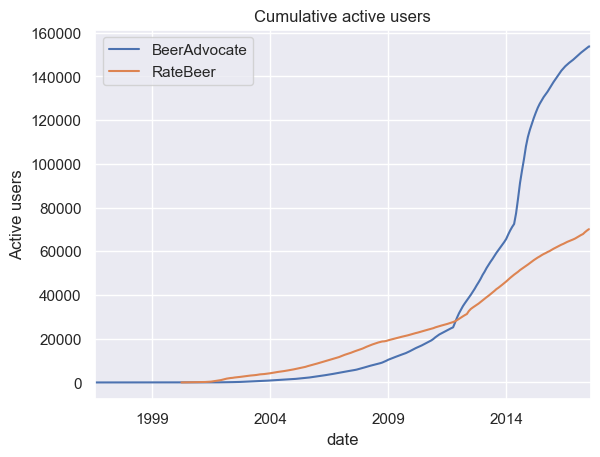

In [351]:
plt.title('Cumulative active users')
plt.xlabel('Month')
plt.ylabel('Active users')
pd.to_datetime(df_ba_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='BeerAdvocate')
pd.to_datetime(df_rb_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='RateBeer')
plt.legend()

In [317]:
def compute_cumulative_ratings_count(dataframe: pd.DataFrame):
    dataframe = dataframe.sort_values(['date'])
    dataframe['_count'] = 1
    dataframe['cumulative_ratings_count'] = dataframe['_count'].cumsum()
    dataframe = dataframe.drop(columns=['_count'])
    return dataframe

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

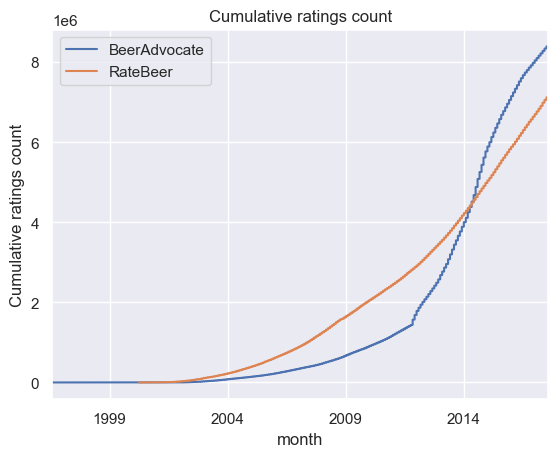

In [352]:
fig, ax = plt.subplots()
plt.title('Cumulative ratings count')
plt.xlabel('Month')
plt.ylabel('Cumulative ratings count')
compute_cumulative_ratings_count(df_ba_ratings).plot(x='month', y='cumulative_ratings_count', label='BeerAdvocate', ax=ax)
compute_cumulative_ratings_count(df_rb_ratings).plot(x='month', y='cumulative_ratings_count', label='RateBeer', ax=ax)

**Internet majority adoption is around 2004 (50% of population using it regularly) + lot of noise before 2004 so the analysis will focus on the time period after January 2004**

In [355]:
def remove_before_month(dataframe: pd.DataFrame, month: str = '2004-01') -> pd.DataFrame:
    dataframe = dataframe.sort_values(['user_id', 'date'])
    dataframe = dataframe.merge(
        (dataframe.groupby('user_id')['month'].first() >= month).reset_index().rename(columns={'month': 'is_first_rating_after_month'}),
        on='user_id'
    )
    dataframe = dataframe[dataframe['is_first_rating_after_month']]
    dataframe = dataframe.drop(columns=['is_first_rating_after_month'])
    return dataframe

In [356]:
df_ba_ratings = remove_before_month(df_ba_ratings, '2004-01')
df_rb_ratings = remove_before_month(df_rb_ratings, '2004-01')

# 1. Inflations

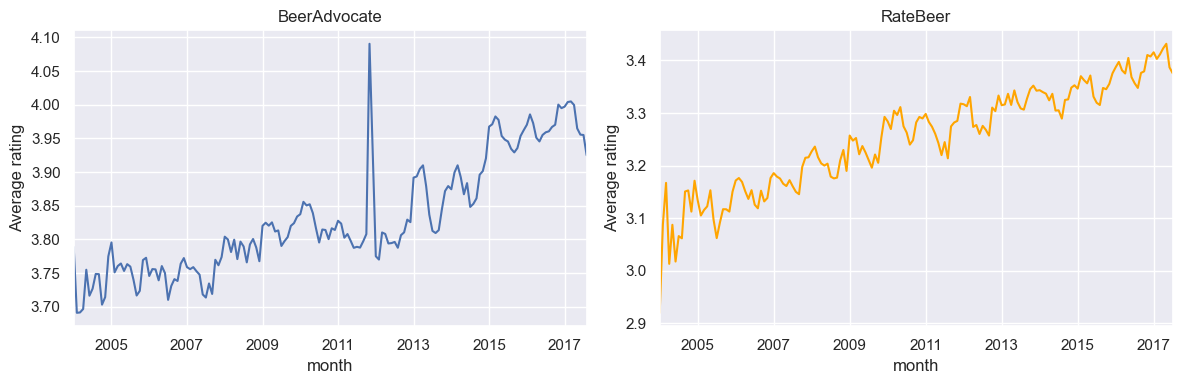

In [385]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Average rating')
df_ba_ratings.groupby('month')['rating'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

In [418]:
def create_time_serie(dataframe: pd.DataFrame, time_column: str, value_column: str, frequency: str = 'W') -> pd.DataFrame:
    full_range = pd.DataFrame(index=pd.date_range(start=dataframe[time_column].min(), end=dataframe[time_column].max(), freq=frequency).to_period('W').start_time)
    partial_time_serie = dataframe.groupby(time_column)[value_column].mean()
    time_serie = pd.merge(full_range, partial_time_serie, left_index=True, right_index=True, how='left').fillna(0)
    return time_serie

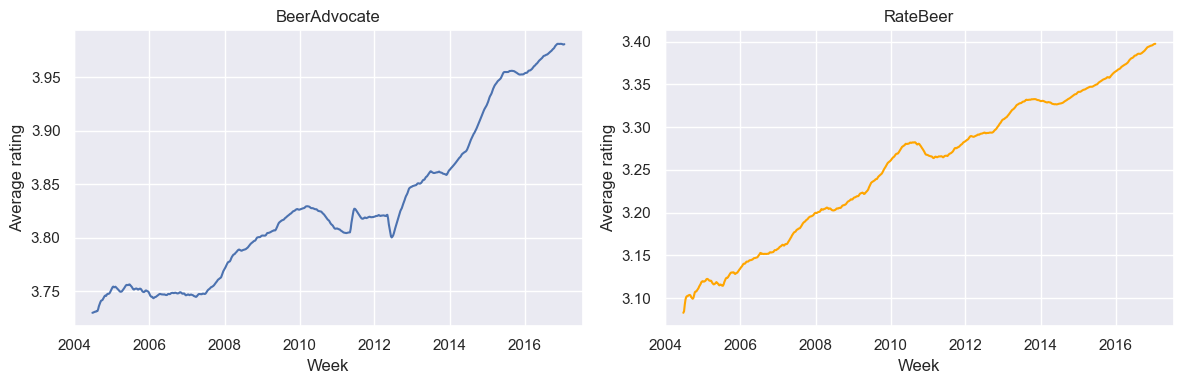

In [425]:
df_ba_decomposition = seasonal_decompose(create_time_serie(df_ba_ratings, 'week', 'rating'), model='additive', period=52)
df_rb_decomposition = seasonal_decompose(create_time_serie(df_rb_ratings, 'week', 'rating'), model='additive', period=52)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating general trend')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average rating')
df_ba_decomposition.trend.plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_decomposition.trend.plot(ax=axs[1], color='orange')

plt.tight_layout()

In [437]:
def correct_inflation(dataframe: pd.DataFrame, trend: pd.Series) -> pd.DataFrame:
    trend = trend.dropna()
    reference_mean = trend.iloc[0]
    IPC = trend / reference_mean
    
    dataframe = dataframe.loc[dataframe['week'] >= trend.index[0]]

    beta_0 = IPC.iloc[0]
    beta_1 = (IPC.iloc[-1] - IPC.iloc[0]) / len(IPC)

    for week in pd.date_range(start=IPC.index.max(), end=dataframe['week'].max(), freq='W').to_period('W').start_time:
        diff = (week + pd.Timedelta(weeks=1) - IPC.index.min()) / pd.Timedelta(weeks=1)
        IPC.loc[week + pd.Timedelta(weeks=1)] = beta_0 + beta_1 * diff
    
    dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values
    return dataframe

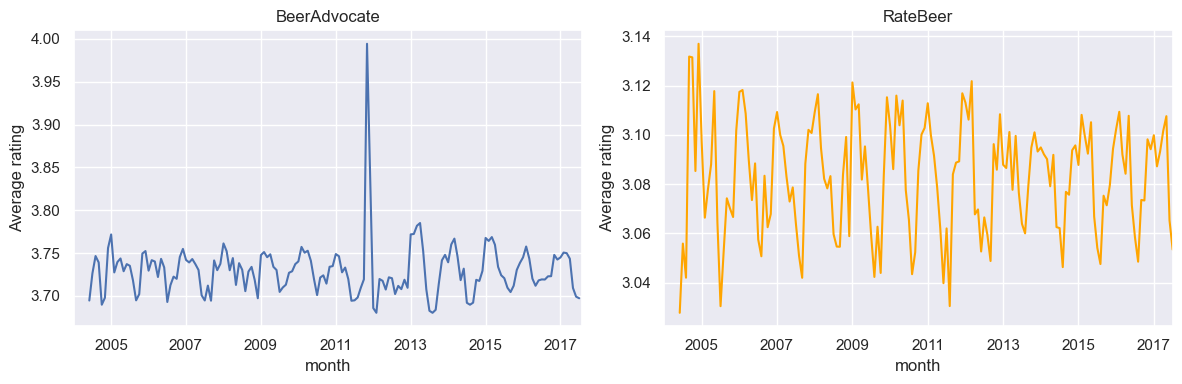

In [ ]:
df_ba_ratings = correct_inflation(df_ba_ratings, df_ba_decomposition.trend)
df_rb_ratings = correct_inflation(df_rb_ratings, df_rb_decomposition.trend)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating average over time corrected for inflation')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average rating')
df_ba_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

# 2. Rating scales

In [598]:
def compute_scale_distribution(dataframe: pd.DataFrame) -> pd.DataFrame:
    new_dataframe = dataframe.groupby('user_id')['rating_corrected'].quantile([0.01, 0.025, 0.05, 0.1, 0.9, 0.95, 0.975, 0.99]).unstack()
    new_dataframe = new_dataframe.merge(dataframe.groupby('user_id')['rating_corrected'].count(), left_index=True, right_index=True)
    new_dataframe = new_dataframe.rename(columns={'rating_corrected': 'count'}).dropna()
    new_dataframe['difference'] = new_dataframe[0.975] - new_dataframe[0.025]
    new_dataframe.columns = [str(c) for c in new_dataframe.columns]
    return new_dataframe

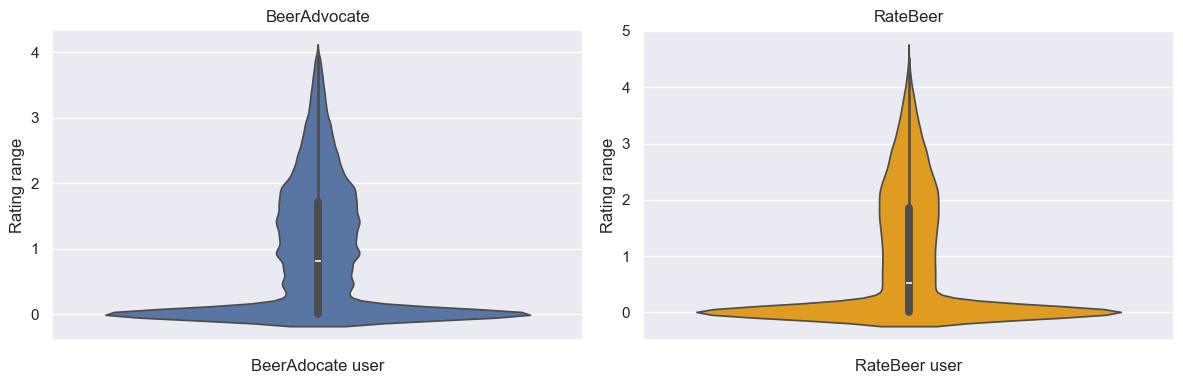

In [599]:
df_ba_scales = compute_scale_distribution(df_ba_ratings)
df_rb_scales = compute_scale_distribution(df_rb_ratings)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Distribution of rating range')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('BeerAdocate user')
axs[0].set_ylabel('Rating range')
sns.violinplot(df_ba_scales['difference'], ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales['difference'], ax=axs[1], color='orange')

plt.tight_layout()

In [600]:
for threshold in [10, 50, 100, 500, 1000]:
    df_ba_scales[f'at_least_{threshold}'] = (df_ba_scales['count'] > threshold).astype(int) * threshold
    df_rb_scales[f'at_least_{threshold}'] = (df_rb_scales['count'] > threshold).astype(int) * threshold

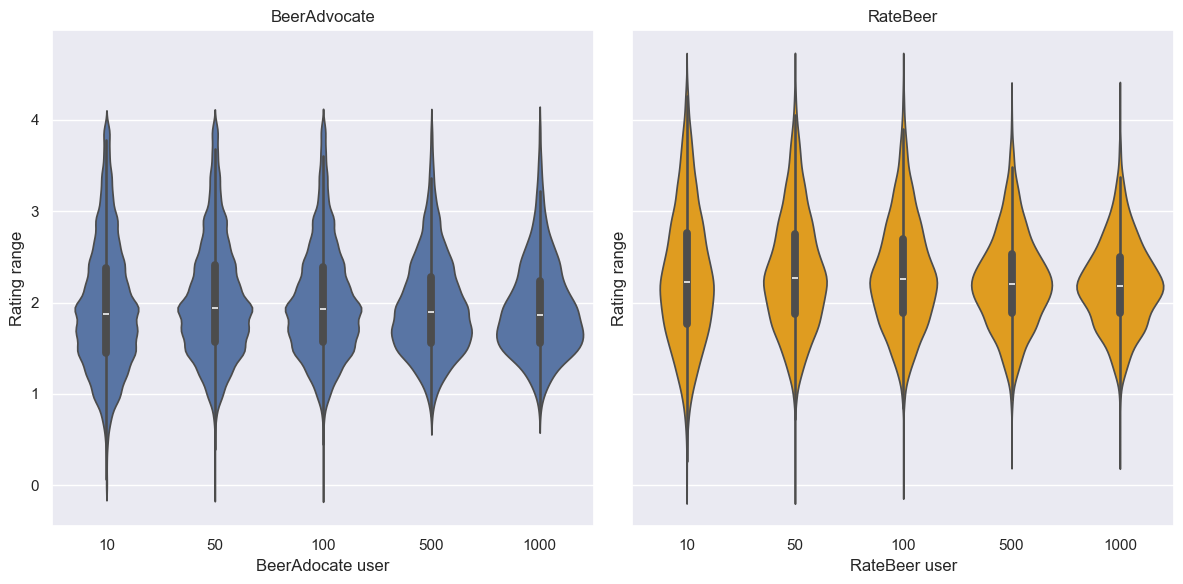

In [ ]:
df_ba_scales = pd.wide_to_long(df_ba_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])
df_rb_scales = pd.wide_to_long(df_rb_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.title('Distribution of rating ranges')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('BeerAdocate user')
axs[0].set_ylabel('Rating range')
sns.violinplot(data=df_ba_scales[df_ba_scales['count'] > df_ba_scales['threshold']], x='threshold', y='difference', ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales[df_rb_scales['count'] > df_rb_scales['threshold']], x='threshold', y='difference', ax=axs[1], color='orange')

plt.tight_layout()